# Lorenz 63 - ODE


In [1]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import xarray as xr
import equinox as eqx

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

In [2]:
# initialize state
state = L63State.init_state(noise=0.01)

x, y, z = state.x, state.y, state.z
print(x.shape, y.shape, z.shape, state.array.shape)

(1,) (1,) (1,) (3,)


In [3]:
sigma, rho, beta = 10, 28, 2.667

In [4]:
# initialize state and params
state, params = L63State.init_state_and_params(noise=0.01, sigma=10, rho=28, beta=2.667)

# rhs
x, y, z = state.x, state.y, state.z
sigma, rho, beta = params.sigma, params.rho, params.beta

state_dot = rhs_lorenz_63(x=x, y=y, z=z, sigma=sigma, rho=rho, beta=beta)

x_dot, y_dot, z_dot = state_dot

assert x.shape == y.shape == z.shape == x_dot.shape
assert x_dot.shape == y_dot.shape == z_dot.shape == x.shape

### Model

In [5]:
# initialize state
state_init, params = L63State.init_state_and_params(
    noise=0.01, sigma=10, rho=28, beta=2.667
)

# initialize model
l63_model = Lorenz63()

# step through
state_dot = l63_model.equation_of_motion(t=0, state=state_init, args=params)

state_dot

L63State(x=Array([0.07530808], dtype=float32), y=Array([25.796669], dtype=float32), z=Array([-1.6745309], dtype=float32))

## Time Stepping

In [6]:
dt = 0.01
t0 = 0.0
t1 = 30.0
# observe_every = 10
ts = jnp.arange(t0, t1, dt)
num_tsteps = len(ts)

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=ts)
saveat

SaveAt(
  subs=SubSaveAt(
    t0=0.0,
    t1=30.0,
    ts=f32[3000],
    steps=False,
    fn=<function save_y>
  ),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [7]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)

In [8]:
sol.ys.x.shape, sol.ts.shape

((3001, 1), (3001,))

In [9]:
ds_sol = xr.Dataset(
    {
        "x": (("time"), sol.ys.x.squeeze()),
        "y": (("time"), sol.ys.y.squeeze()),
        "z": (("time"), sol.ys.z.squeeze()),
    },
    coords={
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_sol

<xarray.Dataset>
Dimensions:  (time: 3001)
Coordinates:
  * time     (time) float32 0.0 0.01 0.02 0.03 0.04 ... 29.97 29.98 29.99 29.99
Data variables:
    x        (time) float32 0.9925 0.9932 1.02 1.069 ... 0.8543 0.9266 0.9266
    y        (time) float32 1.0 1.258 1.514 1.774 ... 1.449 1.578 1.719 1.719
    z        (time) float32 1.0 0.9833 0.9695 0.9591 ... 9.827 9.576 9.334 9.334
Attributes:
    ode:      lorenz_63
    sigma:    10
    beta:     2.667
    rho:      28

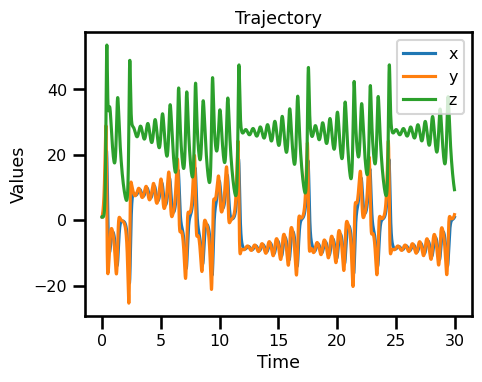

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

ds_sol.x.plot(ax=ax, label="x")
ds_sol.y.plot(ax=ax, label="y")
ds_sol.z.plot(ax=ax, label="z")

ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.set_title("Trajectory")

plt.legend()
plt.tight_layout()
plt.show()

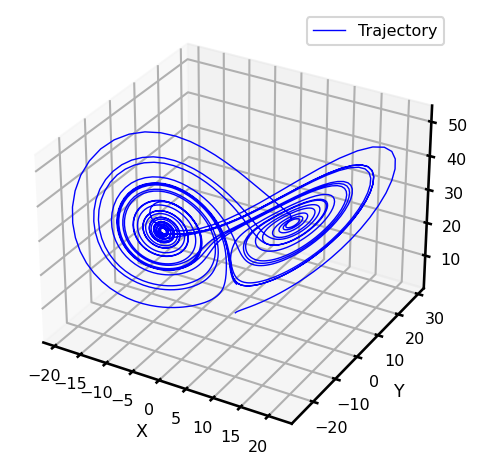

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.x,
    ds_sol.y,
    ds_sol.z,
    lw=1.0,
    color="blue",
    label="Trajectory",
)
# ax.scatter3D(out.x[::10], out.y[::10], out.z[::10], lw=0.5, color="red", label="y")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

## Generating Observations


In [12]:
ds_sol_ = ds_sol.to_array(dim="component", name="simulation").to_dataset()
ds_sol_

<xarray.Dataset>
Dimensions:     (time: 3001, component: 3)
Coordinates:
  * time        (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
  * component   (component) object 'x' 'y' 'z'
Data variables:
    simulation  (component, time) float32 0.9925 0.9932 1.02 ... 9.334 9.334

In [13]:
ds_sol = ds_sol.to_array(dim="component", name="simulation").to_dataset()

ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)

ds_sol

<xarray.Dataset>
Dimensions:       (time: 3001, component: 3)
Coordinates:
  * time          (time) float32 0.0 0.01 0.02 0.03 ... 29.97 29.98 29.99 29.99
  * component     (component) object 'x' 'y' 'z'
Data variables:
    simulation    (component, time) float32 0.9925 0.9932 1.02 ... 9.334 9.334
    observations  (component, time) float32 nan nan nan nan ... nan nan nan nan

### Missing Time

In [14]:
sample_step = 20
ds_sol["observations"] = xr.full_like(ds_sol.simulation, np.nan)
ds_sol["observations"].loc[::sample_step] = ds_sol["simulation"].loc[::sample_step]

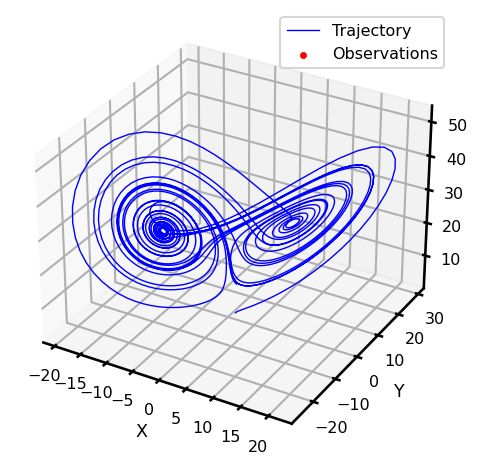

In [15]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"),
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    ds_sol.observations.sel(component="x"),
    ds_sol.observations.sel(component="y"),
    ds_sol.observations.sel(component="z"),
    lw=0.5,
    color="red",
    label="Observations",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

### Adding Noise

In [16]:
# def add_noise(da, sigma=2**.5):
#     return da  + np.random.randn(*da.shape) * sigma

sigma = 2**0.5

ds_sol["observations"] += sigma * np.random.randn(*ds_sol["observations"].shape)

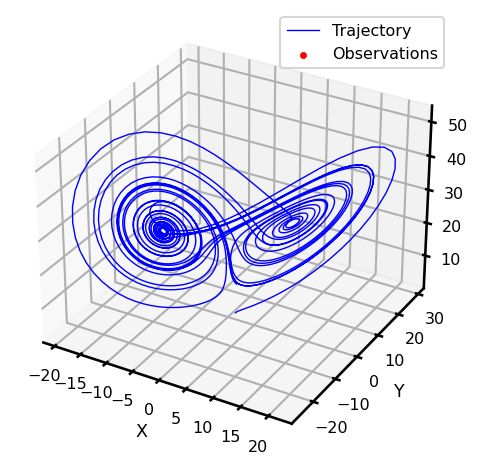

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot(
    ds_sol.simulation.sel(component="x"),
    ds_sol.simulation.sel(component="y"),
    ds_sol.simulation.sel(component="z"),
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    ds_sol.observations.sel(component="x"),
    ds_sol.observations.sel(component="y"),
    ds_sol.observations.sel(component="z"),
    lw=0.5,
    color="red",
    label="Observations",
)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.legend()
plt.tight_layout()
plt.show()

## Batch of Observations

In [18]:
# initialize state
state = L63State.init_state(noise=0.01, batchsize=100)

x, y, z = state.x, state.y, state.z
print(x.shape, y.shape, z.shape, state.array.shape)

# initialize model
l63_model = Lorenz63()

(100, 1) (100, 1) (100, 1) (100, 3)


In [19]:
batchsize = 100
sigma, rho, beta = 10, 28, 2.667

state_batch, params = L63State.init_state_and_params(
    batchsize=batchsize, noise=0.01, sigma=10, rho=28, beta=2.667
)

fn_batched = jax.vmap(rhs_lorenz_63, in_axes=(0, 0, 0, None, None, None))

state_dot_batch = fn_batched(
    state_batch.x, state_batch.y, state_batch.z, sigma, rho, beta
)
x_dot, y_dot, z_dot = state_dot_batch
# state_dot_batch = fn_batched(state_batch)

assert x_dot.shape == y_dot.shape == z_dot.shape == state_batch.x.shape
assert state_batch.x.shape == state_batch.y.shape == state_batch.z.shape == x_dot.shape


fn_batched = jax.vmap(l63_model.equation_of_motion, in_axes=(None, 0, None))

state_dot_batch_ = fn_batched(0, state_batch, params)
x_dot_, y_dot_, z_dot_ = state_dot_batch_
# state_dot_batch = fn_batched(state_batch)

np.testing.assert_array_equal(x_dot, x_dot_)
np.testing.assert_array_equal(y_dot, y_dot_)
np.testing.assert_array_equal(z_dot, z_dot_)
assert x_dot.shape == y_dot.shape == z_dot.shape == state_batch.x.shape
assert state_batch.x.shape == state_batch.y.shape == state_batch.z.shape == x_dot.shape

In [20]:
dt = 0.01
t0 = 0.0
t1 = 30.0
# observe_every = 10
ts = jnp.arange(t0, t1, dt)
num_tsteps = len(ts)

saveat = dfx.SaveAt(t0=t0, t1=t1, ts=ts)
saveat

SaveAt(
  subs=SubSaveAt(
    t0=0.0,
    t1=30.0,
    ts=f32[3000],
    steps=False,
    fn=<function save_y>
  ),
  dense=False,
  solver_state=False,
  controller_state=False,
  made_jump=False
)

In [21]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# integration
integrate = lambda state: dfx.diffeqsolve(
    terms=dfx.ODETerm(l63_model.equation_of_motion),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=state,
    saveat=saveat,
    args=params,
    stepsize_controller=stepsize_controller,
)
sol = jax.vmap(integrate)(state_batch)

In [22]:
state_batch.x.shape, sol.ys.x.shape

((100, 1), (100, 3001, 1))

In [23]:
ds_sol = xr.Dataset(
    {
        "x": (("realization", "time"), sol.ys.x.squeeze()),
        "y": (("realization", "time"), sol.ys.y.squeeze()),
        "z": (("realization", "time"), sol.ys.z.squeeze()),
    },
    coords={
        "time": (["time"], sol.ts[0].squeeze()),
    },
    attrs={
        "ode": "lorenz_63",
        "sigma": params.sigma,
        "beta": params.beta,
        "rho": params.rho,
    },
)

ds_sol

<xarray.Dataset>
Dimensions:  (realization: 100, time: 3001)
Coordinates:
  * time     (time) float32 0.0 0.01 0.02 0.03 0.04 ... 29.97 29.98 29.99 30.0
Dimensions without coordinates: realization
Data variables:
    x        (realization, time) float32 1.001 1.001 1.027 ... 1.127 1.22 1.321
    y        (realization, time) float32 1.0 1.26 1.518 ... 2.056 2.237 2.435
    z        (realization, time) float32 1.0 0.9833 0.9697 ... 10.15 9.904 9.667
Attributes:
    ode:      lorenz_63
    sigma:    10
    beta:     2.667
    rho:      28

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


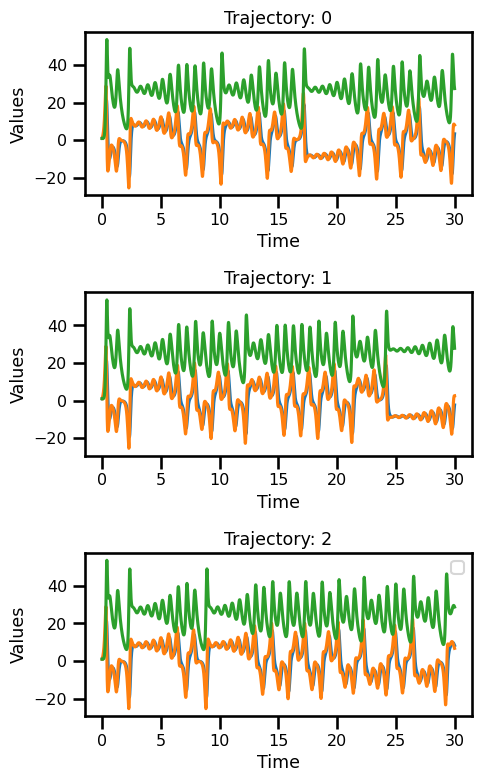

In [24]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))

for i in range(3):
    ds_sol.x.sel(realization=i).plot(ax=ax[i])
    ds_sol.y.sel(realization=i).plot(ax=ax[i])
    ds_sol.z.sel(realization=i).plot(ax=ax[i])

    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Values")
    ax[i].set_title(f"Trajectory: {i}")


plt.legend()
plt.tight_layout()
plt.show()